In [13]:
import os
import pandas as pd

import torch
import torch.nn as nn
import torchaudio.transforms as T
import torchvision
import torch.optim as optim
import scipy as sp
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
import datetime

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [14]:
root_dir = os.path.join('/data', 'EPIC-KITCHENS')
annotations_dir = os.path.join('..', 'data', 'annotations')
train = True
filename_train = 'EPIC_100_train_clean.pkl'
filename_valid = 'EPIC_100_validation.pkl'

img_dir = os.path.join('..','reports','img','dataset_analysis')

In [3]:
def load_data(filename):
    '''
    Load the WAV file and its label.
    Args :
        • filename: str. The path of a WAV file.
    Returns A tuple of two Pandas DataFrame objects:
        • signals: A DataFrame with the following columns:
            • seconds: The time in seconds.
            • AcclX: The acceleration along the x-axis.
            • AcclY: The acceleration along the y-axis.
            • AcclZ: The acceleration along the z-axis.
            • GyroX: The angular velocity along the x-axis.
            • GyroY: The angular velocity along the y-axis.
            • GyroZ: The angular velocity along the z-axis.
        • sampling_rate: The sampling rate of the WAV file.
    '''
    df_accl = pd.read_csv(filename + '-accl.csv').dropna().reset_index(drop=True)
    df_gyro = pd.read_csv(filename + '-gyro.csv').dropna().reset_index(drop=True)

    return df_accl, df_gyro

In [15]:
df = pd.read_pickle(os.path.join(annotations_dir, filename_train))
df = df.dropna()
df = df.reset_index(drop=True)
df

,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes
0,P01,P01_102,00:00:01.100,00:00:00.54,00:00:02.23,27,111,take knife and plate,take,0,knife,4,"[knife, plate]","[4, 2]"
1,P01,P01_102,00:00:07.600,00:00:07.49,00:00:09.05,374,452,move spatula and colander,move,11,spatula,20,"[spatula, colander]","[20, 39]"
2,P01,P01_102,00:00:29.851,00:00:29.66,00:00:30.84,1483,1542,take knife,take,0,knife,4,[knife],[4]
3,P01,P01_102,00:03:44.600,00:03:44.45,00:03:45.00,11222,11250,wipe surface,wipe,2,surface,42,[surface],[42]
4,P01,P01_102,00:03:45.600,00:03:45.61,00:03:46.01,11280,11300,move glass,move,11,glass,10,[glass],[10]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37450,P37,P37_103,00:06:16.903,00:06:17.17,00:06:17.67,18858,18883,turn off tap,turn-off,8,tap,0,[tap],[0]
37451,P37,P37_103,00:06:22.154,00:06:17.86,00:06:23.77,18893,19188,take pan,take,0,pan,5,[pan],[5]
37452,P37,P37_103,00:06:26.404,00:06:23.45,00:06:32.66,19172,19633,pour out boiled water,pour-out,9,water:boiled,27,[water:boiled],[27]
37453,P37,P37_103,00:00:41.151,00:00:40.57,00:00:44.19,2028,2209,debone chicken thighs,debone,30,thigh:chicken,57,[thigh:chicken],[57]


In [7]:
df_valid = pd.read_pickle(os.path.join(annotations_dir, filename_valid))
df_valid = df_valid.dropna()
df_valid = df_valid.reset_index(drop=True)
df_valid

,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes
0,P01,P01_11,00:00:00.560,00:00:00.00,00:00:01.89,1,113,take plate,take,0,plate,2,[plate],[2]
1,P01,P01_11,00:00:01.700,00:00:01.56,00:00:02.45,93,147,put down plate,put-down,1,plate,2,[plate],[2]
2,P01,P01_11,00:00:48.500,00:00:49.15,00:00:50.95,2949,3057,take paper,take,0,paper,49,[paper],[49]
3,P01,P01_11,00:05:27.840,00:05:27.28,00:05:31.97,19636,19918,wash cloth,wash,2,cloth,17,[cloth],[17]
4,P01,P01_11,00:05:26.840,00:05:27.37,00:05:29.86,19642,19791,take cloth,take,0,cloth,17,[cloth],[17]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9593,P32,P32_10,00:01:13.920,00:01:14.36,00:01:17.04,4461,4622,spray degreaser,spray,44,degreaser,22,[degreaser],[22]
9594,P32,P32_10,00:01:17.729,00:01:18.69,00:01:33.75,4721,5625,wash cooker,wash,2,cooker,46,[cooker],[46]
9595,P32,P32_10,00:01:40.790,00:01:39.52,00:01:59.64,5971,7178,rinse cooker,rinse,2,cooker,46,[cooker],[46]
9596,P32,P32_10,00:02:01.070,00:02:00.48,00:02:09.11,7228,7746,rinse cloth,rinse,2,cloth,17,[cloth],[17]


# IMU data size

In [12]:
sz = 0
for video_id in df['video_id'].unique():
    participant_id = video_id.split('_')[0]
    clip_path = os.path.join(root_dir, participant_id, 'meta_data', video_id)
    sz += os.path.getsize(clip_path + '-accl.csv') + os.path.getsize(clip_path + '-gyro.csv')

last = 'bytes'
for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
    if sz < 1024.0:
        last = x
        break
    sz /= 1024.0
print("Data Size: ", sz, last)

Data Size:  3.411542139016092 GB


In [ ]:
accl_data = pd.DataFrame(columns=['video_id', 'Milliseconds', 'AcclX', 'AcclY', 'AcclZ'])
gyro_data = pd.DataFrame(columns=['video_id', 'Milliseconds', 'GyroX', 'GyroY', 'GyroZ'])

In [10]:
df[['verb', 'verb_class']].where(df['verb_class'] == 1).dropna()

,verb,verb_class
12,put-down,1.0
23,put-down,1.0
24,put-down,1.0
26,put-onto,1.0
34,put-down,1.0
...,...,...
37414,put-down,1.0
37421,put-down,1.0
37427,put-down,1.0
37434,put-down,1.0


# 1. Actions Duration

In [5]:
unique_verbs = df['verb'].unique()
unique_verbs

array(['take', 'move', 'wipe', 'throw-into', 'put-down', 'wash', 'pour',
       'turn-off', 'rinse', 'dry', 'put-onto', 'close', 'open',
       'put-into', 'turn-on', 'move-into', 'adjust', 'empty', 'pick-up',
       'put', 'attach-onto', 'pour-into', 'fold', 'shake', 'twist-off',
       'unfold', 'squeeze', 'hand', 'dice', 'stir', 'peel', 'take-from',
       'grind', 'slice', 'take-off', 'tap', 'cut', 'flatten', 'open-with',
       'throw', 'compress', 'separate', 'wipe-off', 'pull-down',
       'take-out', 'remove', 'lift', 'lay', 'pat-down', 'set', 'lather',
       'grab', 'drain', 'scoop', 'spoon', 'immerge', 'spray', 'throw-off',
       'pick', 'check', 'lower', 'move-onto', 'scrape', 'crush',
       'take-up', 'remove-from', 'sprinkle', 'gather', 'wipe-with',
       'press', 'rotate', 'drink', 'crack', 'split', 'eat', 'get',
       'pour-onto', 'press-down', 'distribute', 'move-around', 'flip',
       'hang', 'wrap', 'wrap-around', 'wrap-with', 'fix', 'switch-on',
       'put-in'

## Discrepanza col dataset
Dovrebbero esserci:
* verbs: 97
* nouns: 300

In [5]:
len(df['verb_class'].unique()), len(df['verb'].unique())

(89, 622)

In [6]:
len(df['noun_class'].unique()), len(df['noun'].unique())

(251, 1267)

In [10]:
tmp_df = df
tmp_df['start_timestamp'] = pd.to_datetime(df['start_timestamp'], format='%H:%M:%S.%f')
tmp_df['stop_timestamp'] = pd.to_datetime(df['stop_timestamp'], format='%H:%M:%S.%f')

diff_df = pd.DataFrame({
    'diff': df['stop_timestamp'] - df['start_timestamp'],
    'verb': df['verb'],
    'verb_class': df['verb_class'],
    'noun': df['noun'],
    'noun_class': df['noun_class'],
})

In [11]:
diff_df

,diff,verb,verb_class,noun,noun_class
0,0 days 00:00:01.690000,take,0,knife,4
1,0 days 00:00:01.560000,move,11,spatula,20
2,0 days 00:00:01.180000,take,0,knife,4
3,0 days 00:00:00.550000,wipe,2,surface,42
4,0 days 00:00:00.400000,move,11,glass,10
...,...,...,...,...,...
37450,0 days 00:00:00.500000,turn-off,8,tap,0
37451,0 days 00:00:05.910000,take,0,pan,5
37452,0 days 00:00:09.210000,pour-out,9,water:boiled,27
37453,0 days 00:00:03.620000,debone,30,thigh:chicken,57


In [14]:
diff_df['diff'].describe()

count                        37455
mean     0 days 00:00:02.627286076
std      0 days 00:00:05.191817418
min         0 days 00:00:00.200000
25%         0 days 00:00:00.850000
50%         0 days 00:00:01.340000
75%         0 days 00:00:02.540000
max         0 days 00:04:57.150000
Name: diff, dtype: object

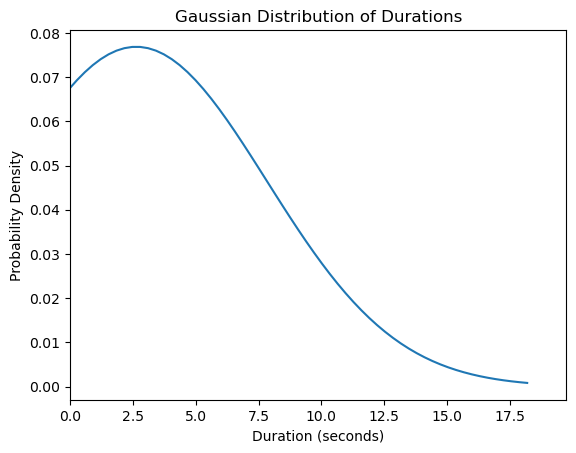

<Figure size 640x480 with 0 Axes>

In [102]:
from scipy.stats import norm
import matplotlib.pyplot as plt

# Calculate mean and standard deviation
mean = diff_df['diff'].mean().total_seconds()
std = diff_df['diff'].std().total_seconds()

# Generate x values for the Gaussian curve
x = np.linspace(mean - 3*std, mean + 3*std, 100)

# Calculate y values using the Gaussian distribution
y = norm.pdf(x, mean, std)

# Plot the Gaussian curve
plt.plot(x, y)
plt.xlabel('Duration (seconds)')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution of Durations')
plt.xlim(left=0)
plt.show()
plt.savefig(os.path.join(img_dir, 'duration_distribution_pdf.svg'))


In [22]:
diff_df['diff'].dt.total_seconds().describe()

count    37455.000000
mean         2.627286
std          5.191817
min          0.200000
25%          0.850000
50%          1.340000
75%          2.540000
max        297.150000
Name: diff, dtype: float64

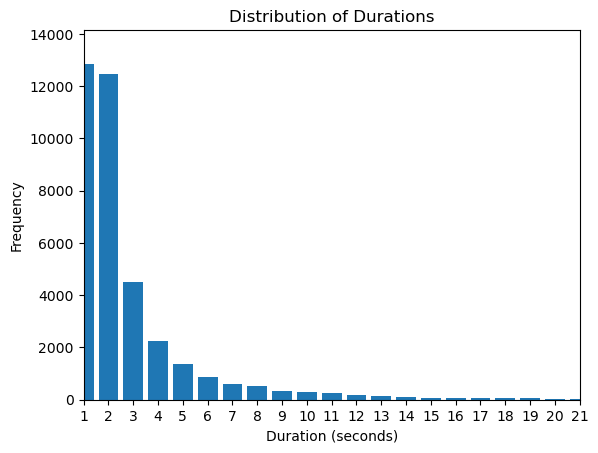

<Figure size 640x480 with 0 Axes>

In [101]:
import matplotlib.pyplot as plt

stats = np.ceil(diff_df['diff'].dt.total_seconds().to_numpy()).astype(int)
limit = 20

labels, counts = np.unique(stats, return_counts=True)
x = np.arange(labels.max())
# Plot the distribution of 'diff' column
plt.bar(labels.astype(str), counts, data=counts, align='center')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Durations')
plt.margins(x=0.01, y=0.1)
plt.xlim(0, 20)
plt.show()
plt.savefig(os.path.join(img_dir, 'duration_distribution_bar.svg'))

# Label frequencies

<Axes: xlabel='verb_class'>

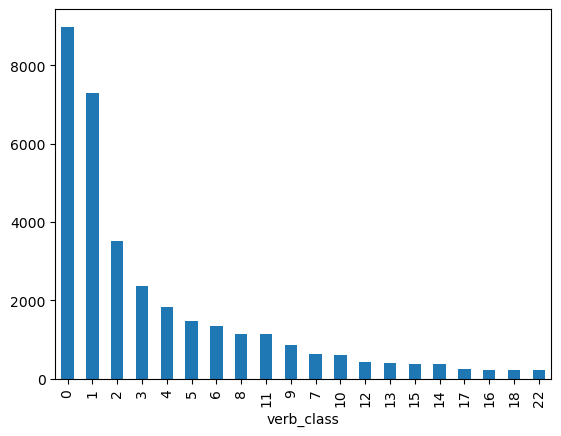

In [5]:
df['verb_class'].value_counts().head(20).plot(kind='bar')

# IMU splits

In [1]:
%cd ..

/home/gatanasio/SSPT_IMU


/home/gatanasio/miniconda3/envs/audio-mae/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
%cd src

/home/gatanasio/SSPT_IMU/src


/home/gatanasio/miniconda3/envs/audio-mae/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [6]:
from data.epic_dataset import EpicDataset
import os

In [18]:
root_dir = os.path.join('/data', 'EPIC-KITCHENS')
annotations_dir = os.path.join('..', 'data', 'annotations')
train = True
filename_train = 'EPIC_100_train_clean.pkl'

In [19]:
dataset = EpicDataset(
    src_dir=root_dir,
    annotations=annotations_dir,
    filename=filename_train,
)

annotations = dataset.annotations

37279


In [20]:
del dataset
len(annotations), len(df)

(37279, 37455)

In [21]:
actions_count_per_pid = annotations['participant_id'].value_counts()
actions_count_per_pid

participant_id
P04    5585
P02    4854
P22    4670
P35    2829
P30    2828
P01    2384
P03    2301
P27    1785
P26    1648
P28    1514
P25    1443
P06    1221
P12    1001
P23     981
P07     821
P11     625
P37     601
P09     188
Name: count, dtype: int64

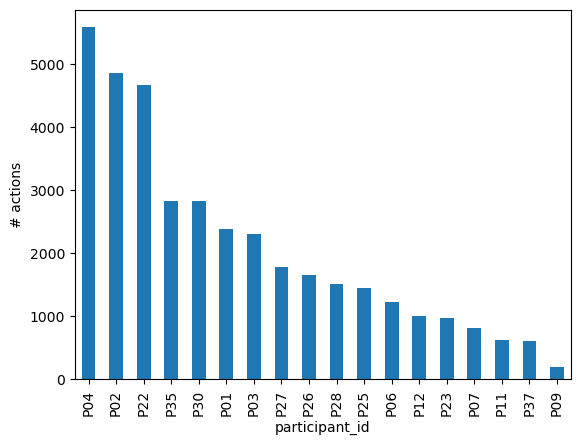

In [22]:
actions_count_per_pid.plot(kind='bar', ylabel='# actions').get_figure().savefig(os.path.join(img_dir, 'num_actions_per_pid.svg'))

In [23]:
total = len(annotations)
val = int(total * 0.1)
test = int(total * 0.15)
train = total - (val + test)
f'{total=}, {train=}, {val=}, {test=}'

'total=37279, train=27961, val=3727, test=5591'

In [24]:
train + val + test

37279

In [25]:
from copy import deepcopy

train_split = {
    'sum': 0,
    'pid_arr': []
}
val_split = deepcopy(train_split)
test_split = deepcopy(train_split)

def create_split(obj: dict, split_num: int):
    for (pid, value) in actions_count_per_pid.items():
        tmp_sum = obj['sum'] + value
        if tmp_sum < split_num:
            obj['sum'] = tmp_sum
            obj['pid_arr'].append(pid)
            actions_count_per_pid.drop(pid, inplace=True)
        else:
            break
    return obj

train_split = create_split(train_split, train)
val_split = create_split(val_split, val)
test_split = create_split(test_split, test)
train_split, val_split, test_split, actions_count_per_pid

({'sum': 27236,
  'pid_arr': ['P04', 'P02', 'P22', 'P35', 'P30', 'P01', 'P03', 'P27']},
 {'sum': 3162, 'pid_arr': ['P26', 'P28']},
 {'sum': 5467, 'pid_arr': ['P25', 'P06', 'P12', 'P23', 'P07']},
 participant_id
 P11    625
 P37    601
 P09    188
 Name: count, dtype: int64)

In [37]:
actions_count_per_pid

participant_id
P11    625
P37    601
P09    188
Name: count, dtype: int64

In [38]:
train_split['sum'] = actions_count_per_pid['P11']
train_split['pid_arr'].append('P11')

val_split['sum'] = actions_count_per_pid['P09']
val_split['pid_arr'].append('P09')

test_split['sum'] = actions_count_per_pid['P37']
test_split['pid_arr'].append('P37')

In [39]:
train_df = annotations.loc[annotations['participant_id'].isin(train_split['pid_arr'])]
val_df = annotations.loc[annotations['participant_id'].isin(val_split['pid_arr'])]
test_df = annotations.loc[annotations['participant_id'].isin(test_split['pid_arr'])]

In [40]:
train_df.to_pickle(os.path.join(annotations_dir, 'EPIC_100_train_clean_split.pkl'))
val_df.to_pickle(os.path.join(annotations_dir, 'EPIC_100_validation_split.pkl'))
test_df.to_pickle(os.path.join(annotations_dir, 'EPIC_100_test_split.pkl'))